In [1]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")
%matplotlib inline

import cv2

from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, Dropout, BatchNormalization, UpSampling2D, Concatenate
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, Callback
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
K.get_session().list_devices()

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 1386130360432),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 1386130359952)]

In [3]:
# Set some parameters

img_size_ori = 101
img_size_target = 128
img_chan = 1
path_train = '../data/train/'
path_test = '../data/test/'

remove_suspicious_masks = True

In [4]:
# Helper functions

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)

    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)


# Define IoU metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)


def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)


def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)


def show_images(image_ids, images_folder, masks_folder=None, predictions=None, prediction_threshold=.5,
                max_images=40, grid_width=8, figsize=(20, 15),                 
                random_sample=False):
    
    grid_height = int(max_images / grid_width)
    ids = np.random.choice(image_ids, size=max_images) if random_sample else image_ids[:max_images]
    images = [np.array(load_img(images_folder + "/{}.png".format(idx), color_mode = "grayscale")) / 255 for idx in tqdm_notebook(ids)]    
    masks = None
    if masks_folder is not None:
        masks = [np.array(load_img(masks_folder + "/{}.png".format(idx), color_mode = "grayscale")) / 255 for idx in tqdm_notebook(ids)]    
    depths_df = pd.read_csv("../data/depths.csv", index_col="id")
    
    fig, axs = plt.subplots(grid_height, grid_width, figsize=figsize)
    
    for i, idx in enumerate(ids):
        ax = axs[int(i / grid_width), i % grid_width]
        ax.imshow(images[i], cmap="Greys")
        ax.set_title(idx)
        ax.text(1, img_size_ori-1, depths_df.loc[idx].z, color="black")
        
        if masks is not None:
            coverage = np.sum(masks[i]) / (img_size_ori * img_size_ori)
            coverage_class = np.trunc(coverage * 10).astype(int)          
            ax.imshow(masks[i], alpha=0.3, cmap="Greens")
            ax.text(img_size_ori - 1, 1, round(coverage, 2), color="black", ha="right", va="top")
            ax.text(1, 1, coverage_class, color="black", ha="left", va="top") 
        
        if predictions is not None:
            pred = predictions[i]
            ax.imshow(np.array(np.round(pred > prediction_threshold), dtype=np.float32), alpha=0.3, cmap="OrRd")       

        ax.set_yticklabels([])
        ax.set_xticklabels([])
    plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")


def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle_decode(rle_mask, shape):
    '''
    rle_mask: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = rle_mask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# Data Exploration
Let's look at some data. We can see that TGS chose to use very varied data by inspecting. That is great and adresses a problem in deep learning geoscience at the moment. We build models on one type of seismic and have no idea whether it generalizes.

In [5]:
train_df = pd.read_csv("../data/train.csv", index_col="id")
depths_df = pd.read_csv("../data/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

train_df["images"] = [np.array(load_img(path_train + "images/{}.png".format(idx), color_mode = "grayscale")) / 255 for idx in tqdm_notebook(train_df.index)]
test_df["images"] = [np.array(load_img(path_test + "images/{}.png".format(idx), color_mode = "grayscale")) / 255 for idx in tqdm_notebook(test_df.index)]

train_df["masks"] = [np.array(load_img(path_train + "masks/{}.png".format(idx), color_mode = "grayscale")) / 255 for idx in tqdm_notebook(train_df.index)]


train_df["coverage"] = train_df.masks.map(np.sum) / (101*101)

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
train_df.fillna('', inplace=True)
train_df['suspicious'] = False

for index, row in train_df.iterrows():
    encoded_mask = row['rle_mask'].split(' ')
    if len(encoded_mask) > 1 and len(encoded_mask) < 5 and int(encoded_mask[1]) % 101 == 0:
        train_df.loc[index,'suspicious'] = True

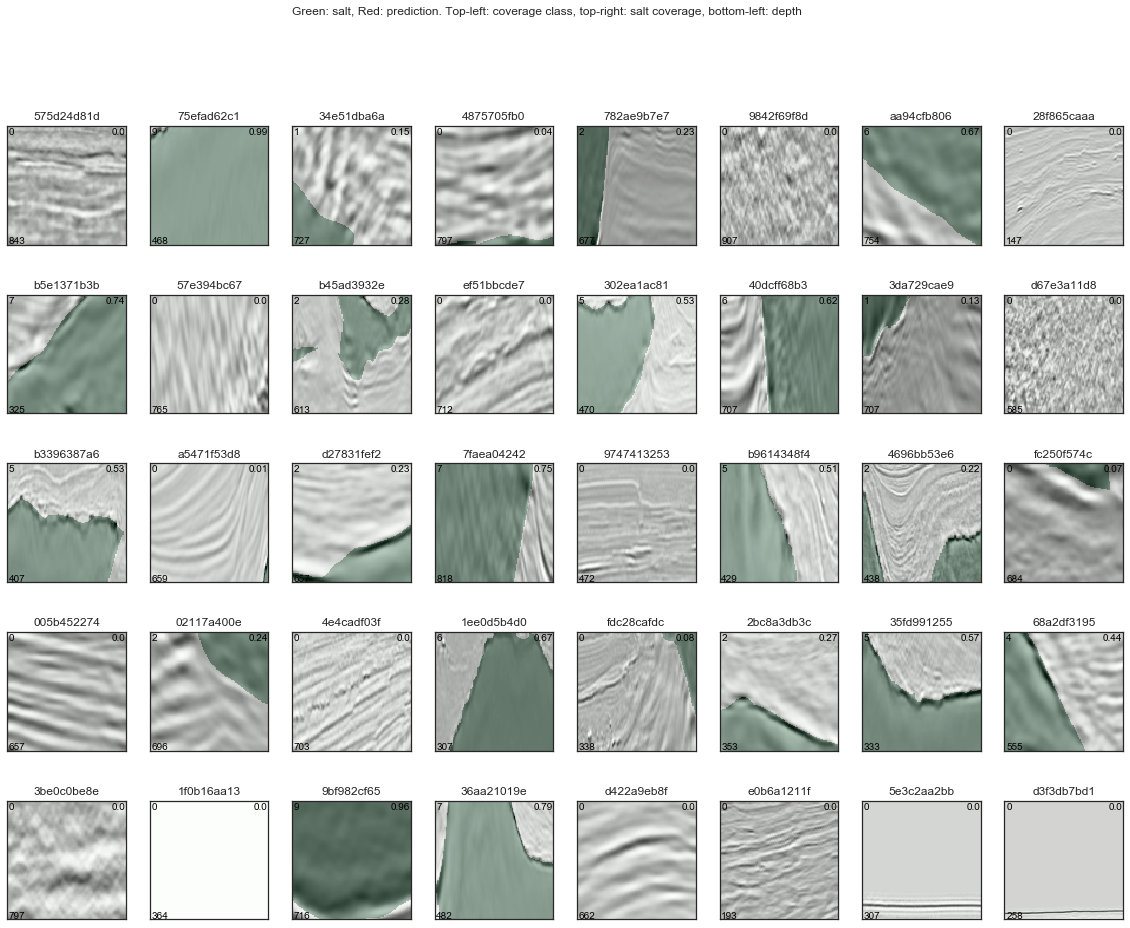

In [7]:
show_images(train_df.loc[train_df.suspicious == False].index, images_folder= path_train + 'images', masks_folder= path_train + 'masks')

## Suspicious masks

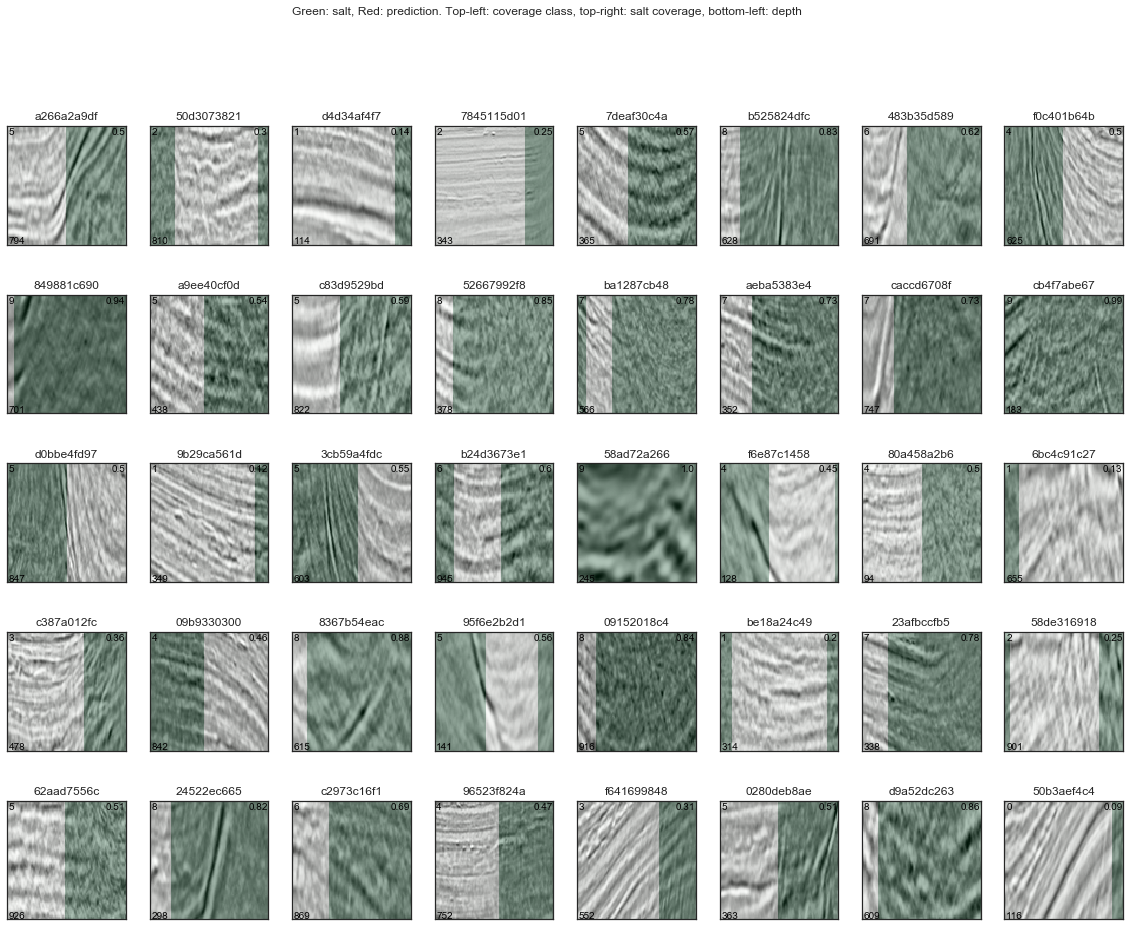

In [8]:
show_images(train_df.loc[train_df.suspicious == True].index, images_folder= path_train + 'images', masks_folder= path_train + 'masks')

In [9]:
if remove_suspicious_masks:
    train_df = train_df.loc[train_df.suspicious == False]

Text(0.5,0,'Coverage class')

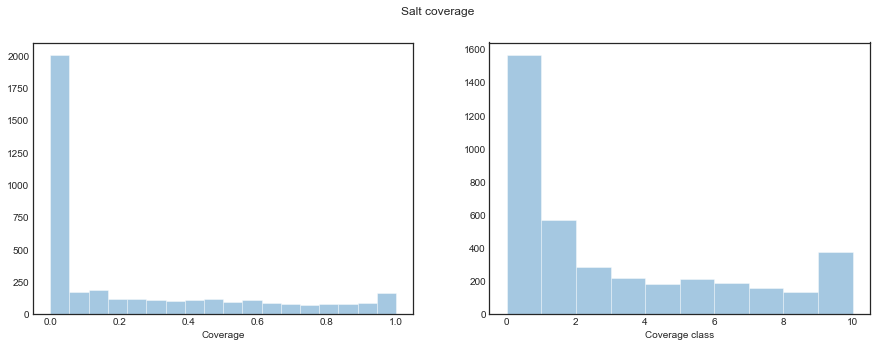

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

In [11]:
low_salt_threshold = 0.0001

print(train_df.loc[train_df.coverage == 0].shape[0])
print(train_df.loc[(train_df.coverage > 0) & (train_df.coverage < low_salt_threshold)].shape[0])

1562
11


coverage        z
coverage   1.00000  0.10236
z          0.10236  1.00000

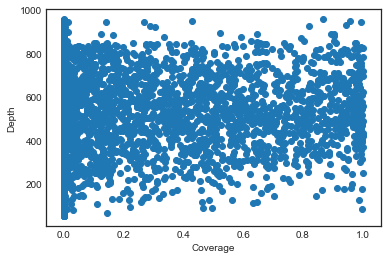

In [12]:
plt.scatter(train_df.coverage, train_df.z)
plt.xlabel("Coverage")
plt.ylabel("Depth")


train_df[['coverage','z']].corr()

Text(0.5,1,'Depth distribution')

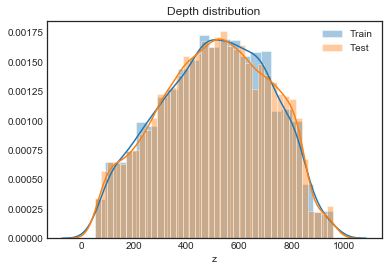

In [13]:
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

In [14]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_valid, depth_train, depth_valid = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=3456)

In [15]:
np.savetxt("validation_ids.csv", ids_valid, fmt='%s')

In [15]:
x_train.shape

(3107, 128, 128, 1)

In [16]:
# data augmentation 
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

Text(0.5,0.98,'Top row: original images, bottom row: augmented images')

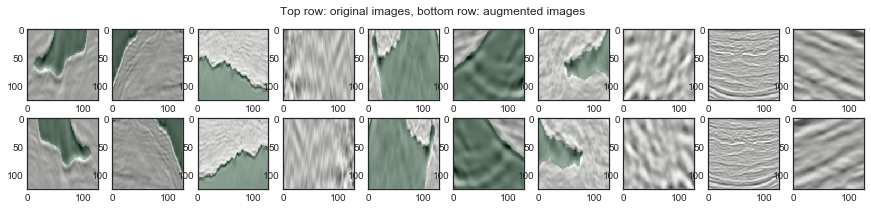

In [17]:
fig, axs = plt.subplots(2, 10, figsize=(15,3))
for i in range(10):
    axs[0][i].imshow(x_train[i].squeeze(), cmap="Greys")
    axs[0][i].imshow(y_train[i].squeeze(), cmap="Greens", alpha=0.3)
    axs[1][i].imshow(x_train[int(len(x_train)/2 + i)].squeeze(), cmap="Greys")
    axs[1][i].imshow(y_train[int(len(y_train)/2 + i)].squeeze(), cmap="Greens", alpha=0.3)
fig.suptitle("Top row: original images, bottom row: augmented images")

# Train Model
Our task, just like the segmentation task for nuclei, is evaluated on the mean IoU metric. This one isn't in keras, but obviously, we're stealing this one too from Ketil.

This is the fun part. Building the sequential Model. The U-Net is basically looking like an Auto-Encoder with shortcuts. 

We're also sprinkling in some earlystopping to prevent overfitting. If you're running this on kaggle, this is the point, you want to have GPU support.

In [68]:
def conv_block(m, dim, acti, bn, res, do=0):
    n = Conv2D(dim, 3, activation=acti, padding='same')(m)
    n = BatchNormalization()(n) if bn else n
    n = Dropout(do)(n) if do else n
    n = Conv2D(dim, 3, activation=acti, padding='same')(n)
    n = BatchNormalization()(n) if bn else n
    return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
    if depth > 0:
        n = conv_block(m, dim, acti, bn, res)
        m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
        m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
        if up:
            m = UpSampling2D()(m)
            m = Conv2D(dim, 2, activation=acti, padding='same')(m)
        else:
            m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
        n = Concatenate()([n, m])
        m = conv_block(n, dim, acti, bn, res)
    else:
        m = conv_block(m, dim, acti, bn, res, do)
    return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
        dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
    i = Input(shape=img_shape)
    o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
    o = Conv2D(out_ch, 1, activation='sigmoid')(o)
    return Model(inputs=i, outputs=o)


model = UNet((img_size_target,img_size_target,1),start_ch=16,depth=5,batchnorm=True,upconv=False)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [81]:
# train the model
batch_size = 16
epochs = 80

earlystopper = EarlyStopping(patience=6, verbose=1)
checkpointer = ModelCheckpoint('../models/model-tgs-salt-validation-dropout-batchnorm-{epoch:02d}-{val_loss:.2f}.h5', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.00001, verbose=1)
tb = TensorBoard(log_dir="../tb_logs", batch_size=batch_size)

history = model.fit(x_train, y_train, validation_data=[x_valid, y_valid], batch_size=batch_size, epochs=epochs, 
                    callbacks=[earlystopper, checkpointer, reduce_lr, tb])

Train on 6214 samples, validate on 777 samples
Epoch 1/80
6214/6214 [==============================] - 1023s - loss: 0.3725 - mean_iou: 0.6215 - val_loss: 1.0868 - val_mean_iou: 0.6572
Epoch 2/80


2976/6214 [=============>................] - ETA: 976s - loss: 0.4259 - mean_iou: 0.65 - ETA: 939s - loss: 0.3883 - mean_iou: 0.65 - ETA: 924s - loss: 0.3425 - mean_iou: 0.65 - ETA: 916s - loss: 0.3248 - mean_iou: 0.65 - ETA: 911s - loss: 0.2943 - mean_iou: 0.65 - ETA: 907s - loss: 0.2917 - mean_iou: 0.65 - ETA: 902s - loss: 0.3256 - mean_iou: 0.65 - ETA: 899s - loss: 0.3401 - mean_iou: 0.65 - ETA: 896s - loss: 0.3299 - mean_iou: 0.65 - ETA: 893s - loss: 0.3181 - mean_iou: 0.65 - ETA: 890s - loss: 0.3162 - mean_iou: 0.65 - ETA: 887s - loss: 0.3261 - mean_iou: 0.65 - ETA: 885s - loss: 0.3168 - mean_iou: 0.65 - ETA: 882s - loss: 0.3147 - mean_iou: 0.65 - ETA: 879s - loss: 0.3066 - mean_iou: 0.65 - ETA: 876s - loss: 0.3052 - mean_iou: 0.65 - ETA: 874s - loss: 0.3114 - mean_iou: 0.65 - ETA: 871s - loss: 0.3097 - mean_iou: 0.65 - ETA: 869s - loss: 0.3094 - mean_iou: 0.65 - ETA: 866s - loss: 0.3058 - mean_iou: 0.65 - ETA: 864s - loss: 0.3059 - mean_iou: 0.65 - ETA: 861s - loss: 0.3035 - mean

6214/6214 [==============================] - 1016s - loss: 0.2450 - mean_iou: 0.6694 - val_loss: 0.1953 - val_mean_iou: 0.6883
Epoch 3/80
6214/6214 [==============================] - 1015s - loss: 0.2202 - mean_iou: 0.6988 - val_loss: 0.3546 - val_mean_iou: 0.7066
Epoch 4/80


2976/6214 [=============>................] - ETA: 905s - loss: 0.2790 - mean_iou: 0.70 - ETA: 906s - loss: 0.2536 - mean_iou: 0.70 - ETA: 904s - loss: 0.2666 - mean_iou: 0.70 - ETA: 901s - loss: 0.2468 - mean_iou: 0.70 - ETA: 898s - loss: 0.2338 - mean_iou: 0.70 - ETA: 895s - loss: 0.2249 - mean_iou: 0.70 - ETA: 893s - loss: 0.2473 - mean_iou: 0.70 - ETA: 890s - loss: 0.2527 - mean_iou: 0.70 - ETA: 888s - loss: 0.2454 - mean_iou: 0.70 - ETA: 885s - loss: 0.2437 - mean_iou: 0.70 - ETA: 883s - loss: 0.2333 - mean_iou: 0.70 - ETA: 881s - loss: 0.2254 - mean_iou: 0.70 - ETA: 879s - loss: 0.2178 - mean_iou: 0.70 - ETA: 876s - loss: 0.2141 - mean_iou: 0.70 - ETA: 874s - loss: 0.2097 - mean_iou: 0.70 - ETA: 872s - loss: 0.2115 - mean_iou: 0.70 - ETA: 869s - loss: 0.2038 - mean_iou: 0.70 - ETA: 867s - loss: 0.2003 - mean_iou: 0.70 - ETA: 865s - loss: 0.2067 - mean_iou: 0.70 - ETA: 862s - loss: 0.2009 - mean_iou: 0.70 - ETA: 860s - loss: 0.2083 - mean_iou: 0.70 - ETA: 857s - loss: 0.2030 - mean

6214/6214 [==============================] - 1015s - loss: 0.2035 - mean_iou: 0.7127 - val_loss: 0.2766 - val_mean_iou: 0.7192
Epoch 5/80
6214/6214 [==============================] - 1016s - loss: 0.1916 - mean_iou: 0.7241 - val_loss: 0.1510 - val_mean_iou: 0.7298
Epoch 6/80


2976/6214 [=============>................] - ETA: 908s - loss: 0.0959 - mean_iou: 0.73 - ETA: 906s - loss: 0.1122 - mean_iou: 0.73 - ETA: 902s - loss: 0.1053 - mean_iou: 0.73 - ETA: 900s - loss: 0.0979 - mean_iou: 0.73 - ETA: 898s - loss: 0.1004 - mean_iou: 0.73 - ETA: 896s - loss: 0.1206 - mean_iou: 0.73 - ETA: 894s - loss: 0.1311 - mean_iou: 0.73 - ETA: 891s - loss: 0.1312 - mean_iou: 0.73 - ETA: 889s - loss: 0.1278 - mean_iou: 0.73 - ETA: 887s - loss: 0.1326 - mean_iou: 0.73 - ETA: 884s - loss: 0.1298 - mean_iou: 0.73 - ETA: 882s - loss: 0.1245 - mean_iou: 0.73 - ETA: 879s - loss: 0.1405 - mean_iou: 0.73 - ETA: 877s - loss: 0.1357 - mean_iou: 0.73 - ETA: 875s - loss: 0.1617 - mean_iou: 0.73 - ETA: 873s - loss: 0.1574 - mean_iou: 0.73 - ETA: 870s - loss: 0.1597 - mean_iou: 0.73 - ETA: 868s - loss: 0.1590 - mean_iou: 0.73 - ETA: 866s - loss: 0.1566 - mean_iou: 0.73 - ETA: 863s - loss: 0.1526 - mean_iou: 0.73 - ETA: 861s - loss: 0.1507 - mean_iou: 0.73 - ETA: 858s - loss: 0.1490 - mean

6214/6214 [==============================] - 1015s - loss: 0.1674 - mean_iou: 0.7362 - val_loss: 0.1715 - val_mean_iou: 0.7419
Epoch 7/80
6214/6214 [==============================] - 1015s - loss: 0.1592 - mean_iou: 0.7466 - val_loss: 0.1362 - val_mean_iou: 0.7516
Epoch 8/80


2976/6214 [=============>................] - ETA: 910s - loss: 0.2431 - mean_iou: 0.75 - ETA: 908s - loss: 0.1962 - mean_iou: 0.75 - ETA: 906s - loss: 0.1762 - mean_iou: 0.75 - ETA: 903s - loss: 0.1452 - mean_iou: 0.75 - ETA: 900s - loss: 0.1304 - mean_iou: 0.75 - ETA: 897s - loss: 0.1346 - mean_iou: 0.75 - ETA: 894s - loss: 0.1247 - mean_iou: 0.75 - ETA: 891s - loss: 0.1216 - mean_iou: 0.75 - ETA: 889s - loss: 0.1171 - mean_iou: 0.75 - ETA: 887s - loss: 0.1405 - mean_iou: 0.75 - ETA: 884s - loss: 0.1497 - mean_iou: 0.75 - ETA: 882s - loss: 0.1446 - mean_iou: 0.75 - ETA: 880s - loss: 0.1426 - mean_iou: 0.75 - ETA: 877s - loss: 0.1513 - mean_iou: 0.75 - ETA: 875s - loss: 0.1506 - mean_iou: 0.75 - ETA: 872s - loss: 0.1493 - mean_iou: 0.75 - ETA: 871s - loss: 0.1522 - mean_iou: 0.75 - ETA: 868s - loss: 0.1498 - mean_iou: 0.75 - ETA: 866s - loss: 0.1540 - mean_iou: 0.75 - ETA: 864s - loss: 0.1511 - mean_iou: 0.75 - ETA: 861s - loss: 0.1513 - mean_iou: 0.75 - ETA: 859s - loss: 0.1490 - mean

6214/6214 [==============================] - 1016s - loss: 0.1465 - mean_iou: 0.7561 - val_loss: 0.1244 - val_mean_iou: 0.7607
Epoch 9/80
6214/6214 [==============================] - 1016s - loss: 0.1445 - mean_iou: 0.7645 - val_loss: 0.1316 - val_mean_iou: 0.7683
Epoch 10/80


2976/6214 [=============>................] - ETA: 905s - loss: 0.0895 - mean_iou: 0.76 - ETA: 903s - loss: 0.0771 - mean_iou: 0.76 - ETA: 902s - loss: 0.2093 - mean_iou: 0.76 - ETA: 900s - loss: 0.2102 - mean_iou: 0.76 - ETA: 898s - loss: 0.1841 - mean_iou: 0.76 - ETA: 895s - loss: 0.1759 - mean_iou: 0.76 - ETA: 893s - loss: 0.1624 - mean_iou: 0.76 - ETA: 891s - loss: 0.1621 - mean_iou: 0.76 - ETA: 889s - loss: 0.1606 - mean_iou: 0.76 - ETA: 887s - loss: 0.1504 - mean_iou: 0.76 - ETA: 885s - loss: 0.1438 - mean_iou: 0.76 - ETA: 882s - loss: 0.1401 - mean_iou: 0.76 - ETA: 880s - loss: 0.1561 - mean_iou: 0.76 - ETA: 878s - loss: 0.1547 - mean_iou: 0.76 - ETA: 876s - loss: 0.1667 - mean_iou: 0.76 - ETA: 873s - loss: 0.1629 - mean_iou: 0.76 - ETA: 871s - loss: 0.1647 - mean_iou: 0.76 - ETA: 869s - loss: 0.1663 - mean_iou: 0.76 - ETA: 866s - loss: 0.1659 - mean_iou: 0.76 - ETA: 864s - loss: 0.1673 - mean_iou: 0.76 - ETA: 861s - loss: 0.1673 - mean_iou: 0.76 - ETA: 859s - loss: 0.1672 - mean

6214/6214 [==============================] - 1016s - loss: 0.1390 - mean_iou: 0.7715 - val_loss: 0.1268 - val_mean_iou: 0.7745
Epoch 11/80
6214/6214 [==============================] - 1017s - loss: 0.1317 - mean_iou: 0.7772 - val_loss: 0.1203 - val_mean_iou: 0.7803
Epoch 12/80


2976/6214 [=============>................] - ETA: 902s - loss: 0.0690 - mean_iou: 0.78 - ETA: 904s - loss: 0.0862 - mean_iou: 0.78 - ETA: 903s - loss: 0.1019 - mean_iou: 0.78 - ETA: 900s - loss: 0.0874 - mean_iou: 0.78 - ETA: 898s - loss: 0.0857 - mean_iou: 0.78 - ETA: 895s - loss: 0.0797 - mean_iou: 0.78 - ETA: 893s - loss: 0.0886 - mean_iou: 0.78 - ETA: 891s - loss: 0.0865 - mean_iou: 0.78 - ETA: 888s - loss: 0.0862 - mean_iou: 0.78 - ETA: 886s - loss: 0.0981 - mean_iou: 0.78 - ETA: 884s - loss: 0.0997 - mean_iou: 0.78 - ETA: 881s - loss: 0.1041 - mean_iou: 0.78 - ETA: 879s - loss: 0.1028 - mean_iou: 0.78 - ETA: 876s - loss: 0.1052 - mean_iou: 0.78 - ETA: 874s - loss: 0.1083 - mean_iou: 0.78 - ETA: 872s - loss: 0.1069 - mean_iou: 0.78 - ETA: 869s - loss: 0.1054 - mean_iou: 0.78 - ETA: 867s - loss: 0.1040 - mean_iou: 0.78 - ETA: 865s - loss: 0.1027 - mean_iou: 0.78 - ETA: 863s - loss: 0.1055 - mean_iou: 0.78 - ETA: 860s - loss: 0.1053 - mean_iou: 0.78 - ETA: 858s - loss: 0.1075 - mean

6214/6214 [==============================] - 1016s - loss: 0.1250 - mean_iou: 0.7830 - val_loss: 0.1124 - val_mean_iou: 0.7857
Epoch 13/80
6214/6214 [==============================] - 1015s - loss: 0.1205 - mean_iou: 0.7884 - val_loss: 0.1168 - val_mean_iou: 0.7907
Epoch 14/80


2976/6214 [=============>................] - ETA: 903s - loss: 0.0591 - mean_iou: 0.79 - ETA: 902s - loss: 0.0814 - mean_iou: 0.79 - ETA: 900s - loss: 0.0831 - mean_iou: 0.79 - ETA: 898s - loss: 0.0974 - mean_iou: 0.79 - ETA: 897s - loss: 0.1302 - mean_iou: 0.79 - ETA: 895s - loss: 0.1275 - mean_iou: 0.79 - ETA: 893s - loss: 0.1227 - mean_iou: 0.79 - ETA: 891s - loss: 0.1139 - mean_iou: 0.79 - ETA: 888s - loss: 0.1122 - mean_iou: 0.79 - ETA: 886s - loss: 0.1141 - mean_iou: 0.79 - ETA: 884s - loss: 0.1388 - mean_iou: 0.79 - ETA: 881s - loss: 0.1331 - mean_iou: 0.79 - ETA: 879s - loss: 0.1382 - mean_iou: 0.79 - ETA: 877s - loss: 0.1323 - mean_iou: 0.79 - ETA: 875s - loss: 0.1289 - mean_iou: 0.79 - ETA: 872s - loss: 0.1249 - mean_iou: 0.79 - ETA: 870s - loss: 0.1218 - mean_iou: 0.79 - ETA: 868s - loss: 0.1183 - mean_iou: 0.79 - ETA: 865s - loss: 0.1145 - mean_iou: 0.79 - ETA: 863s - loss: 0.1117 - mean_iou: 0.79 - ETA: 860s - loss: 0.1090 - mean_iou: 0.79 - ETA: 858s - loss: 0.1174 - mean

6214/6214 [==============================] - 1015s - loss: 0.1212 - mean_iou: 0.7931 - val_loss: 0.1169 - val_mean_iou: 0.7952
Epoch 15/80
6214/6214 [==============================] - 1015s - loss: 0.1092 - mean_iou: 0.7976 - val_loss: 0.1396 - val_mean_iou: 0.7997
Epoch 16/80


2976/6214 [=============>................] - ETA: 906s - loss: 0.0333 - mean_iou: 0.79 - ETA: 904s - loss: 0.0514 - mean_iou: 0.79 - ETA: 900s - loss: 0.0467 - mean_iou: 0.79 - ETA: 898s - loss: 0.0548 - mean_iou: 0.79 - ETA: 896s - loss: 0.1093 - mean_iou: 0.79 - ETA: 894s - loss: 0.1036 - mean_iou: 0.79 - ETA: 892s - loss: 0.1058 - mean_iou: 0.79 - ETA: 890s - loss: 0.1000 - mean_iou: 0.79 - ETA: 888s - loss: 0.0977 - mean_iou: 0.79 - ETA: 886s - loss: 0.0928 - mean_iou: 0.79 - ETA: 884s - loss: 0.0998 - mean_iou: 0.79 - ETA: 882s - loss: 0.1004 - mean_iou: 0.79 - ETA: 879s - loss: 0.0962 - mean_iou: 0.79 - ETA: 876s - loss: 0.1018 - mean_iou: 0.79 - ETA: 874s - loss: 0.1043 - mean_iou: 0.79 - ETA: 872s - loss: 0.1056 - mean_iou: 0.79 - ETA: 869s - loss: 0.1057 - mean_iou: 0.79 - ETA: 867s - loss: 0.1069 - mean_iou: 0.79 - ETA: 865s - loss: 0.1037 - mean_iou: 0.79 - ETA: 862s - loss: 0.1010 - mean_iou: 0.79 - ETA: 860s - loss: 0.1032 - mean_iou: 0.79 - ETA: 858s - loss: 0.1002 - mean

6214/6214 [==============================] - 1015s - loss: 0.1077 - mean_iou: 0.8017 - val_loss: 0.1362 - val_mean_iou: 0.8037
Epoch 17/80
6214/6214 [==============================] - 1016s - loss: 0.0976 - mean_iou: 0.8059 - val_loss: 0.1113 - val_mean_iou: 0.8079
Epoch 18/80


2976/6214 [=============>................] - ETA: 907s - loss: 0.0628 - mean_iou: 0.80 - ETA: 904s - loss: 0.0715 - mean_iou: 0.80 - ETA: 902s - loss: 0.0618 - mean_iou: 0.80 - ETA: 899s - loss: 0.0635 - mean_iou: 0.80 - ETA: 896s - loss: 0.0722 - mean_iou: 0.80 - ETA: 894s - loss: 0.0768 - mean_iou: 0.80 - ETA: 892s - loss: 0.0764 - mean_iou: 0.80 - ETA: 890s - loss: 0.0735 - mean_iou: 0.80 - ETA: 888s - loss: 0.0765 - mean_iou: 0.80 - ETA: 885s - loss: 0.0772 - mean_iou: 0.80 - ETA: 883s - loss: 0.0762 - mean_iou: 0.80 - ETA: 881s - loss: 0.0759 - mean_iou: 0.80 - ETA: 879s - loss: 0.0740 - mean_iou: 0.80 - ETA: 876s - loss: 0.0871 - mean_iou: 0.80 - ETA: 874s - loss: 0.0921 - mean_iou: 0.80 - ETA: 872s - loss: 0.0897 - mean_iou: 0.80 - ETA: 869s - loss: 0.0873 - mean_iou: 0.80 - ETA: 867s - loss: 0.0863 - mean_iou: 0.80 - ETA: 865s - loss: 0.0876 - mean_iou: 0.80 - ETA: 862s - loss: 0.0856 - mean_iou: 0.80 - ETA: 860s - loss: 0.0850 - mean_iou: 0.80 - ETA: 858s - loss: 0.0835 - mean

6214/6214 [==============================] - 1015s - loss: 0.0959 - mean_iou: 0.8097 - val_loss: 0.1189 - val_mean_iou: 0.8115
Epoch 19/80
6214/6214 [==============================] - 1015s - loss: 0.0921 - mean_iou: 0.8132 - val_loss: 0.1018 - val_mean_iou: 0.8151
Epoch 20/80


2976/6214 [=============>................] - ETA: 910s - loss: 0.0551 - mean_iou: 0.81 - ETA: 906s - loss: 0.0553 - mean_iou: 0.81 - ETA: 903s - loss: 0.0508 - mean_iou: 0.81 - ETA: 900s - loss: 0.0474 - mean_iou: 0.81 - ETA: 897s - loss: 0.0538 - mean_iou: 0.81 - ETA: 895s - loss: 0.0515 - mean_iou: 0.81 - ETA: 893s - loss: 0.0498 - mean_iou: 0.81 - ETA: 890s - loss: 0.0577 - mean_iou: 0.81 - ETA: 888s - loss: 0.0559 - mean_iou: 0.81 - ETA: 885s - loss: 0.0555 - mean_iou: 0.81 - ETA: 883s - loss: 0.0545 - mean_iou: 0.81 - ETA: 880s - loss: 0.0576 - mean_iou: 0.81 - ETA: 878s - loss: 0.0554 - mean_iou: 0.81 - ETA: 876s - loss: 0.0563 - mean_iou: 0.81 - ETA: 874s - loss: 0.0545 - mean_iou: 0.81 - ETA: 871s - loss: 0.0635 - mean_iou: 0.81 - ETA: 869s - loss: 0.0638 - mean_iou: 0.81 - ETA: 867s - loss: 0.0624 - mean_iou: 0.81 - ETA: 865s - loss: 0.0633 - mean_iou: 0.81 - ETA: 862s - loss: 0.0756 - mean_iou: 0.81 - ETA: 860s - loss: 0.0815 - mean_iou: 0.81 - ETA: 858s - loss: 0.0909 - mean

6214/6214 [==============================] - 1015s - loss: 0.0910 - mean_iou: 0.8169 - val_loss: 0.1065 - val_mean_iou: 0.8186
Epoch 21/80
6214/6214 [==============================] - 1015s - loss: 0.0789 - mean_iou: 0.8204 - val_loss: 0.2085 - val_mean_iou: 0.8218
Epoch 22/80


2976/6214 [=============>................] - ETA: 906s - loss: 0.0667 - mean_iou: 0.82 - ETA: 902s - loss: 0.0660 - mean_iou: 0.82 - ETA: 900s - loss: 0.0630 - mean_iou: 0.82 - ETA: 898s - loss: 0.0679 - mean_iou: 0.82 - ETA: 895s - loss: 0.0682 - mean_iou: 0.82 - ETA: 893s - loss: 0.0684 - mean_iou: 0.82 - ETA: 891s - loss: 0.0704 - mean_iou: 0.82 - ETA: 889s - loss: 0.0699 - mean_iou: 0.82 - ETA: 887s - loss: 0.0870 - mean_iou: 0.82 - ETA: 884s - loss: 0.0930 - mean_iou: 0.82 - ETA: 882s - loss: 0.0922 - mean_iou: 0.82 - ETA: 880s - loss: 0.1114 - mean_iou: 0.82 - ETA: 878s - loss: 0.1243 - mean_iou: 0.82 - ETA: 876s - loss: 0.1309 - mean_iou: 0.82 - ETA: 874s - loss: 0.1297 - mean_iou: 0.82 - ETA: 872s - loss: 0.1274 - mean_iou: 0.82 - ETA: 870s - loss: 0.1243 - mean_iou: 0.82 - ETA: 867s - loss: 0.1220 - mean_iou: 0.82 - ETA: 865s - loss: 0.1197 - mean_iou: 0.82 - ETA: 862s - loss: 0.1249 - mean_iou: 0.82 - ETA: 860s - loss: 0.1392 - mean_iou: 0.82 - ETA: 858s - loss: 0.1375 - mean

6214/6214 [==============================] - 1015s - loss: 0.1018 - mean_iou: 0.8224 - val_loss: 0.0997 - val_mean_iou: 0.8236
Epoch 23/80
6214/6214 [==============================] - 1016s - loss: 0.0800 - mean_iou: 0.8251 - val_loss: 0.0990 - val_mean_iou: 0.8267
Epoch 24/80


2976/6214 [=============>................] - ETA: 904s - loss: 0.0379 - mean_iou: 0.82 - ETA: 903s - loss: 0.0381 - mean_iou: 0.82 - ETA: 902s - loss: 0.0487 - mean_iou: 0.82 - ETA: 899s - loss: 0.0511 - mean_iou: 0.82 - ETA: 896s - loss: 0.0553 - mean_iou: 0.82 - ETA: 895s - loss: 0.0554 - mean_iou: 0.82 - ETA: 892s - loss: 0.0551 - mean_iou: 0.82 - ETA: 890s - loss: 0.0585 - mean_iou: 0.82 - ETA: 887s - loss: 0.0563 - mean_iou: 0.82 - ETA: 885s - loss: 0.0582 - mean_iou: 0.82 - ETA: 883s - loss: 0.0572 - mean_iou: 0.82 - ETA: 881s - loss: 0.0611 - mean_iou: 0.82 - ETA: 879s - loss: 0.0599 - mean_iou: 0.82 - ETA: 876s - loss: 0.0596 - mean_iou: 0.82 - ETA: 874s - loss: 0.0574 - mean_iou: 0.82 - ETA: 872s - loss: 0.0567 - mean_iou: 0.82 - ETA: 869s - loss: 0.0562 - mean_iou: 0.82 - ETA: 867s - loss: 0.0608 - mean_iou: 0.82 - ETA: 864s - loss: 0.0596 - mean_iou: 0.82 - ETA: 862s - loss: 0.0593 - mean_iou: 0.82 - ETA: 860s - loss: 0.0593 - mean_iou: 0.82 - ETA: 857s - loss: 0.0631 - mean

6214/6214 [==============================] - 1015s - loss: 0.0784 - mean_iou: 0.8282 - val_loss: 0.1105 - val_mean_iou: 0.8296
Epoch 25/80
6214/6214 [==============================] - 1015s - loss: 0.0734 - mean_iou: 0.8311 - val_loss: 0.1113 - val_mean_iou: 0.8325
Epoch 26/80


2976/6214 [=============>................] - ETA: 902s - loss: 0.0658 - mean_iou: 0.83 - ETA: 901s - loss: 0.0496 - mean_iou: 0.83 - ETA: 900s - loss: 0.0908 - mean_iou: 0.83 - ETA: 898s - loss: 0.0758 - mean_iou: 0.83 - ETA: 898s - loss: 0.0772 - mean_iou: 0.83 - ETA: 895s - loss: 0.0706 - mean_iou: 0.83 - ETA: 893s - loss: 0.0709 - mean_iou: 0.83 - ETA: 891s - loss: 0.0669 - mean_iou: 0.83 - ETA: 888s - loss: 0.0691 - mean_iou: 0.83 - ETA: 886s - loss: 0.0667 - mean_iou: 0.83 - ETA: 883s - loss: 0.0633 - mean_iou: 0.83 - ETA: 881s - loss: 0.0645 - mean_iou: 0.83 - ETA: 879s - loss: 0.0663 - mean_iou: 0.83 - ETA: 876s - loss: 0.0669 - mean_iou: 0.83 - ETA: 874s - loss: 0.0681 - mean_iou: 0.83 - ETA: 872s - loss: 0.0657 - mean_iou: 0.83 - ETA: 869s - loss: 0.0640 - mean_iou: 0.83 - ETA: 867s - loss: 0.0651 - mean_iou: 0.83 - ETA: 865s - loss: 0.0646 - mean_iou: 0.83 - ETA: 862s - loss: 0.0636 - mean_iou: 0.83 - ETA: 860s - loss: 0.0638 - mean_iou: 0.83 - ETA: 858s - loss: 0.0663 - mean

6214/6214 [==============================] - 1015s - loss: 0.0658 - mean_iou: 0.8340 - val_loss: 0.1049 - val_mean_iou: 0.8354
Epoch 27/80
6214/6214 [==============================] - 1015s - loss: 0.0654 - mean_iou: 0.8369 - val_loss: 0.1213 - val_mean_iou: 0.8381
Epoch 28/80


2976/6214 [=============>................] - ETA: 907s - loss: 0.0499 - mean_iou: 0.83 - ETA: 904s - loss: 0.0514 - mean_iou: 0.83 - ETA: 902s - loss: 0.0618 - mean_iou: 0.83 - ETA: 900s - loss: 0.0559 - mean_iou: 0.83 - ETA: 898s - loss: 0.0543 - mean_iou: 0.83 - ETA: 895s - loss: 0.0541 - mean_iou: 0.83 - ETA: 893s - loss: 0.0611 - mean_iou: 0.83 - ETA: 891s - loss: 0.0689 - mean_iou: 0.83 - ETA: 889s - loss: 0.0655 - mean_iou: 0.83 - ETA: 886s - loss: 0.0641 - mean_iou: 0.83 - ETA: 884s - loss: 0.0627 - mean_iou: 0.83 - ETA: 881s - loss: 0.0659 - mean_iou: 0.83 - ETA: 879s - loss: 0.0661 - mean_iou: 0.83 - ETA: 877s - loss: 0.0674 - mean_iou: 0.83 - ETA: 874s - loss: 0.0664 - mean_iou: 0.83 - ETA: 872s - loss: 0.0644 - mean_iou: 0.83 - ETA: 870s - loss: 0.1120 - mean_iou: 0.83 - ETA: 867s - loss: 0.1076 - mean_iou: 0.83 - ETA: 865s - loss: 0.1036 - mean_iou: 0.83 - ETA: 862s - loss: 0.1014 - mean_iou: 0.83 - ETA: 860s - loss: 0.1004 - mean_iou: 0.83 - ETA: 858s - loss: 0.0988 - mean

6214/6214 [==============================] - 1016s - loss: 0.0710 - mean_iou: 0.8393 - val_loss: 0.0974 - val_mean_iou: 0.8405
Epoch 29/80
6214/6214 [==============================] - 1015s - loss: 0.0747 - mean_iou: 0.8415 - val_loss: 0.1892 - val_mean_iou: 0.8424
Epoch 30/80


2976/6214 [=============>................] - ETA: 905s - loss: 0.0598 - mean_iou: 0.84 - ETA: 904s - loss: 0.1588 - mean_iou: 0.84 - ETA: 902s - loss: 0.1434 - mean_iou: 0.84 - ETA: 899s - loss: 0.1489 - mean_iou: 0.84 - ETA: 897s - loss: 0.1319 - mean_iou: 0.84 - ETA: 895s - loss: 0.1308 - mean_iou: 0.84 - ETA: 893s - loss: 0.1239 - mean_iou: 0.84 - ETA: 891s - loss: 0.1148 - mean_iou: 0.84 - ETA: 888s - loss: 0.1074 - mean_iou: 0.84 - ETA: 885s - loss: 0.1134 - mean_iou: 0.84 - ETA: 883s - loss: 0.1084 - mean_iou: 0.84 - ETA: 881s - loss: 0.1255 - mean_iou: 0.84 - ETA: 879s - loss: 0.1211 - mean_iou: 0.84 - ETA: 877s - loss: 0.1245 - mean_iou: 0.84 - ETA: 874s - loss: 0.1250 - mean_iou: 0.84 - ETA: 872s - loss: 0.1229 - mean_iou: 0.84 - ETA: 870s - loss: 0.1211 - mean_iou: 0.84 - ETA: 868s - loss: 0.1184 - mean_iou: 0.84 - ETA: 865s - loss: 0.1162 - mean_iou: 0.84 - ETA: 863s - loss: 0.1129 - mean_iou: 0.84 - ETA: 860s - loss: 0.1092 - mean_iou: 0.84 - ETA: 858s - loss: 0.1056 - mean

6214/6214 [==============================] - 1016s - loss: 0.0676 - mean_iou: 0.8435 - val_loss: 0.1248 - val_mean_iou: 0.8445
Epoch 31/80
6214/6214 [==============================] - 1015s - loss: 0.0648 - mean_iou: 0.8456 - val_loss: 0.1205 - val_mean_iou: 0.8466
Epoch 32/80


2976/6214 [=============>................] - ETA: 904s - loss: 0.0471 - mean_iou: 0.84 - ETA: 902s - loss: 0.0480 - mean_iou: 0.84 - ETA: 901s - loss: 0.0538 - mean_iou: 0.84 - ETA: 899s - loss: 0.0872 - mean_iou: 0.84 - ETA: 897s - loss: 0.0766 - mean_iou: 0.84 - ETA: 895s - loss: 0.0830 - mean_iou: 0.84 - ETA: 893s - loss: 0.0780 - mean_iou: 0.84 - ETA: 891s - loss: 0.0742 - mean_iou: 0.84 - ETA: 888s - loss: 0.0758 - mean_iou: 0.84 - ETA: 886s - loss: 0.0734 - mean_iou: 0.84 - ETA: 884s - loss: 0.0686 - mean_iou: 0.84 - ETA: 881s - loss: 0.0644 - mean_iou: 0.84 - ETA: 879s - loss: 0.0633 - mean_iou: 0.84 - ETA: 877s - loss: 0.0669 - mean_iou: 0.84 - ETA: 874s - loss: 0.0671 - mean_iou: 0.84 - ETA: 872s - loss: 0.0681 - mean_iou: 0.84 - ETA: 870s - loss: 0.0682 - mean_iou: 0.84 - ETA: 867s - loss: 0.0700 - mean_iou: 0.84 - ETA: 865s - loss: 0.0677 - mean_iou: 0.84 - ETA: 863s - loss: 0.0664 - mean_iou: 0.84 - ETA: 861s - loss: 0.0652 - mean_iou: 0.84 - ETA: 858s - loss: 0.0655 - mean

6214/6214 [==============================] - 1015s - loss: 0.0586 - mean_iou: 0.8476 - val_loss: 0.0999 - val_mean_iou: 0.8487
Epoch 33/80
6214/6214 [==============================] - 1015s - loss: 0.0537 - mean_iou: 0.8498 - val_loss: 0.1033 - val_mean_iou: 0.8510
Epoch 34/80


2976/6214 [=============>................] - ETA: 902s - loss: 0.0215 - mean_iou: 0.85 - ETA: 902s - loss: 0.0317 - mean_iou: 0.85 - ETA: 900s - loss: 0.0400 - mean_iou: 0.85 - ETA: 898s - loss: 0.0382 - mean_iou: 0.85 - ETA: 895s - loss: 0.0409 - mean_iou: 0.85 - ETA: 894s - loss: 0.0408 - mean_iou: 0.85 - ETA: 891s - loss: 0.0582 - mean_iou: 0.85 - ETA: 890s - loss: 0.0565 - mean_iou: 0.85 - ETA: 887s - loss: 0.0567 - mean_iou: 0.85 - ETA: 885s - loss: 0.0554 - mean_iou: 0.85 - ETA: 883s - loss: 0.0536 - mean_iou: 0.85 - ETA: 880s - loss: 0.0537 - mean_iou: 0.85 - ETA: 878s - loss: 0.0541 - mean_iou: 0.85 - ETA: 876s - loss: 0.0522 - mean_iou: 0.85 - ETA: 873s - loss: 0.0516 - mean_iou: 0.85 - ETA: 871s - loss: 0.0577 - mean_iou: 0.85 - ETA: 869s - loss: 0.0563 - mean_iou: 0.85 - ETA: 866s - loss: 0.0551 - mean_iou: 0.85 - ETA: 864s - loss: 0.0599 - mean_iou: 0.85 - ETA: 862s - loss: 0.0581 - mean_iou: 0.85 - ETA: 859s - loss: 0.0573 - mean_iou: 0.85 - ETA: 857s - loss: 0.0559 - mean

6208/6214 [============================>.] - ETA: 36s - loss: 0.0551 - mean_iou: 0.851 - ETA: 33s - loss: 0.0551 - mean_iou: 0.851 - ETA: 31s - loss: 0.0551 - mean_iou: 0.852 - ETA: 29s - loss: 0.0551 - mean_iou: 0.852 - ETA: 26s - loss: 0.0550 - mean_iou: 0.852 - ETA: 24s - loss: 0.0550 - mean_iou: 0.852 - ETA: 21s - loss: 0.0550 - mean_iou: 0.852 - ETA: 19s - loss: 0.0550 - mean_iou: 0.852 - ETA: 17s - loss: 0.0549 - mean_iou: 0.852 - ETA: 14s - loss: 0.0548 - mean_iou: 0.852 - ETA: 12s - loss: 0.0548 - mean_iou: 0.852 - ETA: 10s - loss: 0.0548 - mean_iou: 0.852 - ETA: 7s - loss: 0.0547 - mean_iou: 0.852 - ETA: 5s - loss: 0.0548 - mean_iou: 0.85 - ETA: 3s - loss: 0.0547 - mean_iou: 0.85 - ETA: 0s - loss: 0.0555 - mean_iou: 0.8520Epoch 00033: val_loss did not improve

Epoch 00033: reducing learning rate to 0.00020000000949949026.
6214/6214 [==============================] - 1016s - loss: 0.0555 - mean_iou: 0.8520 - val_loss: 0.1001 - val_mean_iou: 0.8530
Epoch 35/80
6214/6214 [=======

2976/6214 [=============>................] - ETA: 907s - loss: 0.0216 - mean_iou: 0.85 - ETA: 903s - loss: 0.0222 - mean_iou: 0.85 - ETA: 901s - loss: 0.0273 - mean_iou: 0.85 - ETA: 898s - loss: 0.0287 - mean_iou: 0.85 - ETA: 896s - loss: 0.0337 - mean_iou: 0.85 - ETA: 893s - loss: 0.0346 - mean_iou: 0.85 - ETA: 891s - loss: 0.0349 - mean_iou: 0.85 - ETA: 889s - loss: 0.0332 - mean_iou: 0.85 - ETA: 887s - loss: 0.0313 - mean_iou: 0.85 - ETA: 884s - loss: 0.0337 - mean_iou: 0.85 - ETA: 882s - loss: 0.0342 - mean_iou: 0.85 - ETA: 879s - loss: 0.0340 - mean_iou: 0.85 - ETA: 877s - loss: 0.0354 - mean_iou: 0.85 - ETA: 875s - loss: 0.0360 - mean_iou: 0.85 - ETA: 873s - loss: 0.0368 - mean_iou: 0.85 - ETA: 870s - loss: 0.0358 - mean_iou: 0.85 - ETA: 868s - loss: 0.0361 - mean_iou: 0.85 - ETA: 866s - loss: 0.0356 - mean_iou: 0.85 - ETA: 864s - loss: 0.0354 - mean_iou: 0.85 - ETA: 861s - loss: 0.0346 - mean_iou: 0.85 - ETA: 859s - loss: 0.0343 - mean_iou: 0.85 - ETA: 857s - loss: 0.0355 - mean

6214/6214 [==============================] - 1014s - loss: 0.0396 - mean_iou: 0.8563 - val_loss: 0.0989 - val_mean_iou: 0.8574
Epoch 37/80
6214/6214 [==============================] - 1014s - loss: 0.0371 - mean_iou: 0.8585 - val_loss: 0.0990 - val_mean_iou: 0.8596
Epoch 38/80


2976/6214 [=============>................] - ETA: 905s - loss: 0.0382 - mean_iou: 0.85 - ETA: 902s - loss: 0.0331 - mean_iou: 0.85 - ETA: 900s - loss: 0.0323 - mean_iou: 0.85 - ETA: 897s - loss: 0.0301 - mean_iou: 0.85 - ETA: 896s - loss: 0.0288 - mean_iou: 0.85 - ETA: 894s - loss: 0.0318 - mean_iou: 0.85 - ETA: 892s - loss: 0.0311 - mean_iou: 0.85 - ETA: 890s - loss: 0.0340 - mean_iou: 0.85 - ETA: 887s - loss: 0.0359 - mean_iou: 0.85 - ETA: 885s - loss: 0.0366 - mean_iou: 0.85 - ETA: 883s - loss: 0.0368 - mean_iou: 0.85 - ETA: 881s - loss: 0.0378 - mean_iou: 0.85 - ETA: 878s - loss: 0.0385 - mean_iou: 0.85 - ETA: 876s - loss: 0.0369 - mean_iou: 0.85 - ETA: 874s - loss: 0.0366 - mean_iou: 0.85 - ETA: 871s - loss: 0.0366 - mean_iou: 0.85 - ETA: 869s - loss: 0.0365 - mean_iou: 0.85 - ETA: 866s - loss: 0.0364 - mean_iou: 0.85 - ETA: 864s - loss: 0.0373 - mean_iou: 0.85 - ETA: 862s - loss: 0.0367 - mean_iou: 0.85 - ETA: 859s - loss: 0.0365 - mean_iou: 0.85 - ETA: 857s - loss: 0.0371 - mean

6214/6214 [==============================] - 1015s - loss: 0.0361 - mean_iou: 0.8606 - val_loss: 0.0992 - val_mean_iou: 0.8617
Epoch 39/80
6214/6214 [==============================] - 1015s - loss: 0.0356 - mean_iou: 0.8627 - val_loss: 0.1082 - val_mean_iou: 0.8636
Epoch 40/80


2976/6214 [=============>................] - ETA: 907s - loss: 0.0249 - mean_iou: 0.86 - ETA: 905s - loss: 0.0291 - mean_iou: 0.86 - ETA: 903s - loss: 0.0331 - mean_iou: 0.86 - ETA: 900s - loss: 0.0325 - mean_iou: 0.86 - ETA: 899s - loss: 0.0321 - mean_iou: 0.86 - ETA: 896s - loss: 0.0305 - mean_iou: 0.86 - ETA: 894s - loss: 0.0294 - mean_iou: 0.86 - ETA: 891s - loss: 0.0314 - mean_iou: 0.86 - ETA: 888s - loss: 0.0306 - mean_iou: 0.86 - ETA: 886s - loss: 0.0302 - mean_iou: 0.86 - ETA: 884s - loss: 0.0301 - mean_iou: 0.86 - ETA: 881s - loss: 0.0306 - mean_iou: 0.86 - ETA: 879s - loss: 0.0316 - mean_iou: 0.86 - ETA: 876s - loss: 0.0305 - mean_iou: 0.86 - ETA: 874s - loss: 0.0307 - mean_iou: 0.86 - ETA: 872s - loss: 0.0309 - mean_iou: 0.86 - ETA: 869s - loss: 0.0306 - mean_iou: 0.86 - ETA: 867s - loss: 0.0310 - mean_iou: 0.86 - ETA: 865s - loss: 0.0313 - mean_iou: 0.86 - ETA: 862s - loss: 0.0318 - mean_iou: 0.86 - ETA: 860s - loss: 0.0316 - mean_iou: 0.86 - ETA: 858s - loss: 0.0309 - mean

6214/6214 [==============================] - 1015s - loss: 0.0358 - mean_iou: 0.8646 - val_loss: 0.1108 - val_mean_iou: 0.8655
Epoch 41/80
2976/6214 [=============>................] - ETA: 905s - loss: 0.0386 - mean_iou: 0.86 - ETA: 904s - loss: 0.0407 - mean_iou: 0.86 - ETA: 902s - loss: 0.0388 - mean_iou: 0.86 - ETA: 900s - loss: 0.0397 - mean_iou: 0.86 - ETA: 897s - loss: 0.0398 - mean_iou: 0.86 - ETA: 895s - loss: 0.0404 - mean_iou: 0.86 - ETA: 892s - loss: 0.0395 - mean_iou: 0.86 - ETA: 890s - loss: 0.0374 - mean_iou: 0.86 - ETA: 888s - loss: 0.0372 - mean_iou: 0.86 - ETA: 886s - loss: 0.0351 - mean_iou: 0.86 - ETA: 883s - loss: 0.0350 - mean_iou: 0.86 - ETA: 881s - loss: 0.0332 - mean_iou: 0.86 - ETA: 879s - loss: 0.0326 - mean_iou: 0.86 - ETA: 876s - loss: 0.0312 - mean_iou: 0.86 - ETA: 874s - loss: 0.0306 - mean_iou: 0.86 - ETA: 872s - loss: 0.0305 - mean_iou: 0.86 - ETA: 869s - loss: 0.0304 - mean_iou: 0.86 - ETA: 867s - loss: 0.0312 - mean_iou: 0.86 - ETA: 865s - loss: 0.0320

2976/6214 [=============>................] - ETA: 903s - loss: 0.0614 - mean_iou: 0.86 - ETA: 903s - loss: 0.0415 - mean_iou: 0.86 - ETA: 901s - loss: 0.0363 - mean_iou: 0.86 - ETA: 899s - loss: 0.0399 - mean_iou: 0.86 - ETA: 898s - loss: 0.0498 - mean_iou: 0.86 - ETA: 894s - loss: 0.0483 - mean_iou: 0.86 - ETA: 892s - loss: 0.0459 - mean_iou: 0.86 - ETA: 890s - loss: 0.0460 - mean_iou: 0.86 - ETA: 887s - loss: 0.0448 - mean_iou: 0.86 - ETA: 885s - loss: 0.0452 - mean_iou: 0.86 - ETA: 883s - loss: 0.0435 - mean_iou: 0.86 - ETA: 880s - loss: 0.0427 - mean_iou: 0.86 - ETA: 878s - loss: 0.0418 - mean_iou: 0.86 - ETA: 876s - loss: 0.0400 - mean_iou: 0.86 - ETA: 874s - loss: 0.0399 - mean_iou: 0.86 - ETA: 871s - loss: 0.0404 - mean_iou: 0.86 - ETA: 869s - loss: 0.0395 - mean_iou: 0.86 - ETA: 867s - loss: 0.0387 - mean_iou: 0.86 - ETA: 864s - loss: 0.0380 - mean_iou: 0.86 - ETA: 862s - loss: 0.0373 - mean_iou: 0.86 - ETA: 859s - loss: 0.0362 - mean_iou: 0.86 - ETA: 857s - loss: 0.0364 - mean

6214/6214 [==============================] - 1014s - loss: 0.0327 - mean_iou: 0.8683 - val_loss: 0.1048 - val_mean_iou: 0.8692
Epoch 43/80
6214/6214 [==============================] - 1015s - loss: 0.0325 - mean_iou: 0.8700 - val_loss: 0.1061 - val_mean_iou: 0.8709
Epoch 44/80


2976/6214 [=============>................] - ETA: 906s - loss: 0.0387 - mean_iou: 0.87 - ETA: 902s - loss: 0.0375 - mean_iou: 0.87 - ETA: 900s - loss: 0.0423 - mean_iou: 0.87 - ETA: 899s - loss: 0.0357 - mean_iou: 0.87 - ETA: 897s - loss: 0.0354 - mean_iou: 0.87 - ETA: 894s - loss: 0.0334 - mean_iou: 0.87 - ETA: 892s - loss: 0.0330 - mean_iou: 0.87 - ETA: 890s - loss: 0.0300 - mean_iou: 0.87 - ETA: 887s - loss: 0.0317 - mean_iou: 0.87 - ETA: 885s - loss: 0.0305 - mean_iou: 0.87 - ETA: 883s - loss: 0.0292 - mean_iou: 0.87 - ETA: 881s - loss: 0.0284 - mean_iou: 0.87 - ETA: 878s - loss: 0.0287 - mean_iou: 0.87 - ETA: 876s - loss: 0.0312 - mean_iou: 0.87 - ETA: 873s - loss: 0.0333 - mean_iou: 0.87 - ETA: 871s - loss: 0.0335 - mean_iou: 0.87 - ETA: 869s - loss: 0.0337 - mean_iou: 0.87 - ETA: 866s - loss: 0.0340 - mean_iou: 0.87 - ETA: 864s - loss: 0.0346 - mean_iou: 0.87 - ETA: 862s - loss: 0.0340 - mean_iou: 0.87 - ETA: 860s - loss: 0.0340 - mean_iou: 0.87 - ETA: 857s - loss: 0.0337 - mean

6214/6214 [==============================] - 1014s - loss: 0.0321 - mean_iou: 0.8717 - val_loss: 0.1065 - val_mean_iou: 0.8725
Epoch 45/80
6214/6214 [==============================] - 1015s - loss: 0.0318 - mean_iou: 0.8733 - val_loss: 0.1045 - val_mean_iou: 0.8741
Epoch 46/80


2976/6214 [=============>................] - ETA: 906s - loss: 0.0228 - mean_iou: 0.87 - ETA: 904s - loss: 0.0288 - mean_iou: 0.87 - ETA: 903s - loss: 0.0261 - mean_iou: 0.87 - ETA: 899s - loss: 0.0284 - mean_iou: 0.87 - ETA: 897s - loss: 0.0267 - mean_iou: 0.87 - ETA: 894s - loss: 0.0287 - mean_iou: 0.87 - ETA: 891s - loss: 0.0284 - mean_iou: 0.87 - ETA: 889s - loss: 0.0278 - mean_iou: 0.87 - ETA: 886s - loss: 0.0302 - mean_iou: 0.87 - ETA: 884s - loss: 0.0304 - mean_iou: 0.87 - ETA: 882s - loss: 0.0301 - mean_iou: 0.87 - ETA: 880s - loss: 0.0299 - mean_iou: 0.87 - ETA: 877s - loss: 0.0291 - mean_iou: 0.87 - ETA: 875s - loss: 0.0293 - mean_iou: 0.87 - ETA: 873s - loss: 0.0304 - mean_iou: 0.87 - ETA: 870s - loss: 0.0303 - mean_iou: 0.87 - ETA: 868s - loss: 0.0297 - mean_iou: 0.87 - ETA: 865s - loss: 0.0297 - mean_iou: 0.87 - ETA: 863s - loss: 0.0292 - mean_iou: 0.87 - ETA: 861s - loss: 0.0293 - mean_iou: 0.87 - ETA: 859s - loss: 0.0291 - mean_iou: 0.87 - ETA: 857s - loss: 0.0290 - mean

6208/6214 [============================>.] - ETA: 36s - loss: 0.0320 - mean_iou: 0.874 - ETA: 33s - loss: 0.0319 - mean_iou: 0.874 - ETA: 31s - loss: 0.0319 - mean_iou: 0.874 - ETA: 28s - loss: 0.0319 - mean_iou: 0.874 - ETA: 26s - loss: 0.0319 - mean_iou: 0.874 - ETA: 24s - loss: 0.0319 - mean_iou: 0.874 - ETA: 21s - loss: 0.0318 - mean_iou: 0.874 - ETA: 19s - loss: 0.0318 - mean_iou: 0.874 - ETA: 17s - loss: 0.0318 - mean_iou: 0.874 - ETA: 14s - loss: 0.0318 - mean_iou: 0.874 - ETA: 12s - loss: 0.0319 - mean_iou: 0.874 - ETA: 10s - loss: 0.0319 - mean_iou: 0.874 - ETA: 7s - loss: 0.0318 - mean_iou: 0.874 - ETA: 5s - loss: 0.0318 - mean_iou: 0.87 - ETA: 3s - loss: 0.0318 - mean_iou: 0.87 - ETA: 0s - loss: 0.0318 - mean_iou: 0.8748Epoch 00045: val_loss did not improve

Epoch 00045: reducing learning rate to 1e-05.
6214/6214 [==============================] - 1015s - loss: 0.0318 - mean_iou: 0.8748 - val_loss: 0.1042 - val_mean_iou: 0.8756
Epoch 00045: early stopping


NameError: name 'history' is not defined

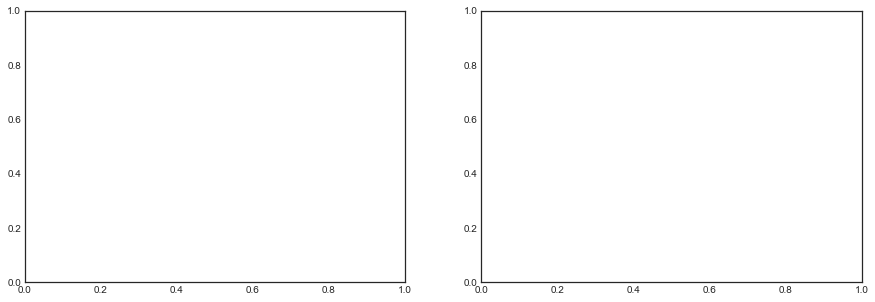

In [36]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))

ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["mean_iou"], label="Train Mean_IoU")
ax_acc.plot(history.epoch, history.history["val_mean_iou"], label="Validation Mean_IoU")


In [19]:
best_model = load_model('../models/model-tgs-salt-validation-dropout-batchnorm-34-0.10.h5',
                       custom_objects={"mean_iou": mean_iou})

C:\Anaconda\envs\py35\lib\site-packages\keras\engine\saving.py:304: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


# Predict the validation set to do a sanity check

Again plot some sample images including the predictions.

In [53]:
preds_valid = best_model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([train_df.loc[idx].masks for idx in ids_valid])

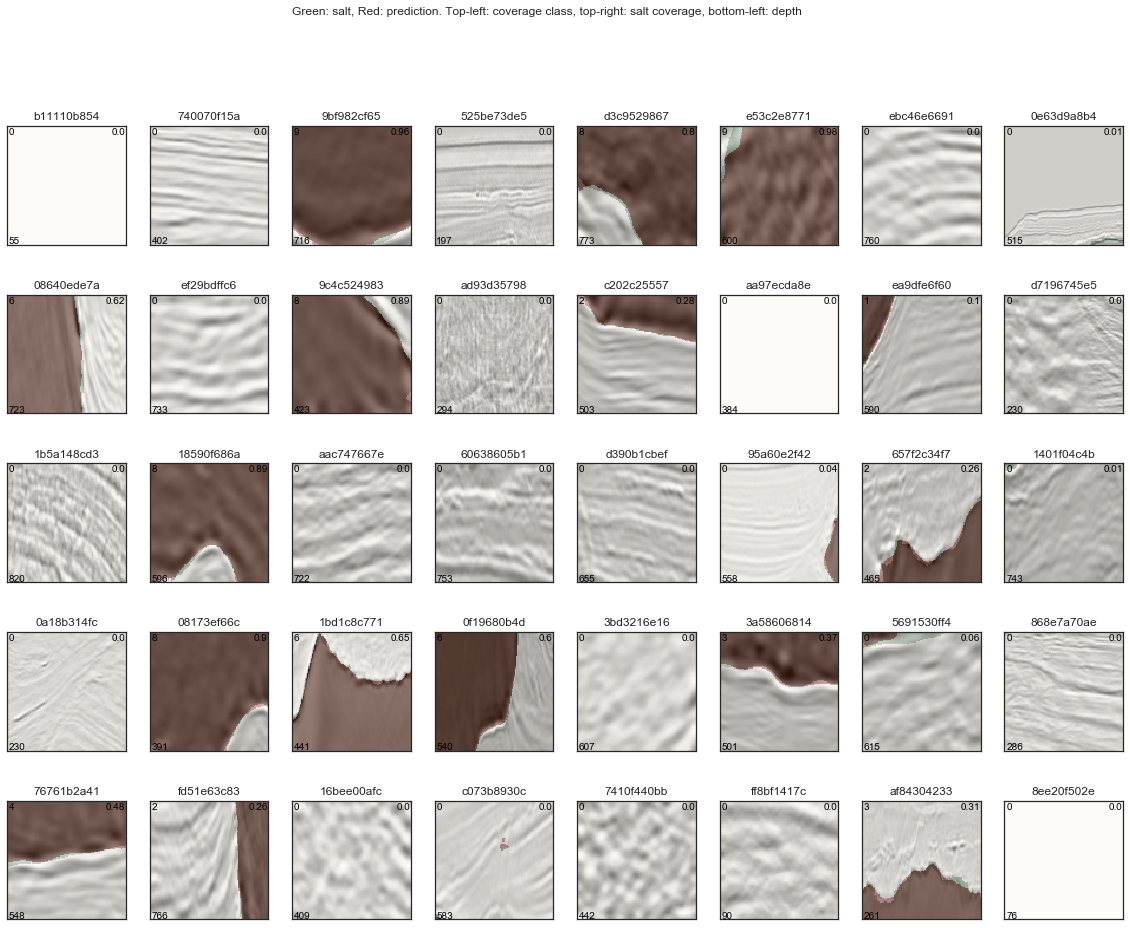

In [55]:
show_images(ids_valid, images_folder= path_train + 'images', masks_folder= path_train + 'masks',
           predictions=preds_valid)

In [56]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

In [57]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

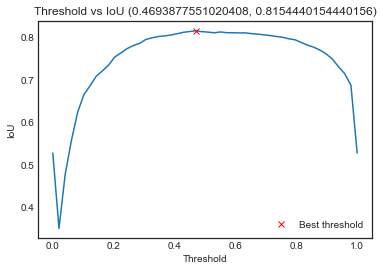

In [58]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

# Submission

In [25]:
x_test = np.array([upsample(np.array(load_img("../data/test/images/{}.png".format(idx), color_mode = "grayscale"))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

preds_test = best_model.predict(x_test)

C:\Anaconda\envs\py35\lib\site-packages\keras_preprocessing\image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [26]:
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

# Difficult cases analysis

In [45]:
valid_df = pd.DataFrame(ids_valid, columns=["index"])
valid_df["pred"] = [np.round(pred > threshold_best) for pred in preds_valid]
valid_df["mask"] = [np.array(load_img(path_train + "masks/{}.png".format(idx), color_mode = "grayscale")) / 255 for idx in tqdm_notebook(ids_valid)]
valid_df["coverage"] = valid_df["mask"].map(np.sum) / (101*101)
valid_df["coverage_class"] = valid_df.coverage.map(lambda x: np.trunc(x*10).astype(int))
valid_df["pred_coverage"] = valid_df["pred"].map(np.sum) / (101*101)
valid_df["pred_coverage_class"] = valid_df.pred_coverage.map(lambda x: np.trunc(x*10).astype(int))

def iou_metric_row(row):
    return iou_metric(row["mask"], row["pred"])

valid_df["iou"] = valid_df.apply(iou_metric_row, axis=1)
valid_df["outcome"] = valid_df["iou"].apply(lambda x: "good" if x > 0.8 else "average" if x > 0.2 else "bad")
valid_df = valid_df.sort_values(by="iou")

C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:118: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


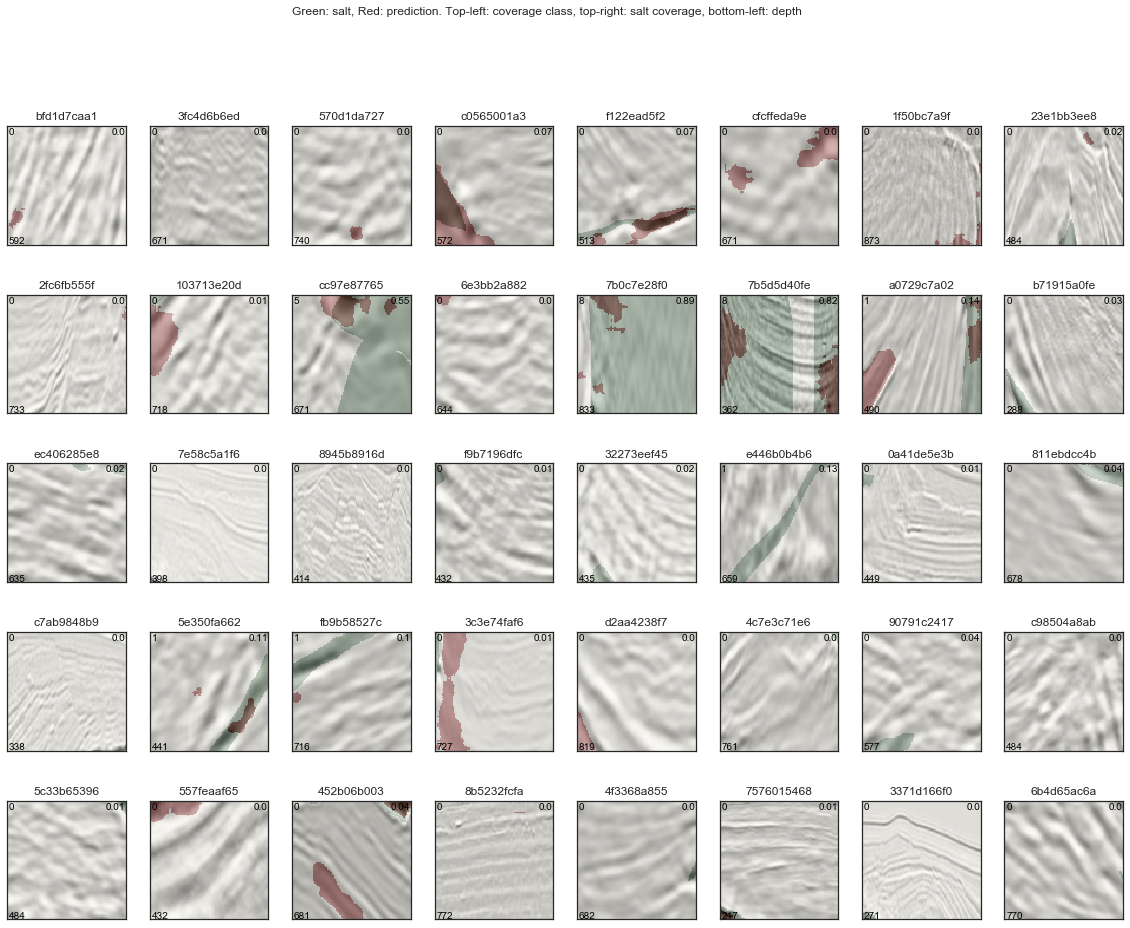

In [36]:
show_images(np.array(valid_df["index"]), images_folder= path_train + 'images', masks_folder= path_train + 'masks',
           predictions=np.array(valid_df["pred"]))

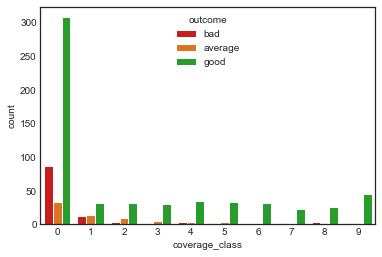

In [37]:
sns.countplot(x="coverage_class", hue="outcome", data=valid_df, palette=sns.xkcd_palette(["red", "orange", "green"]))

C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:118: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


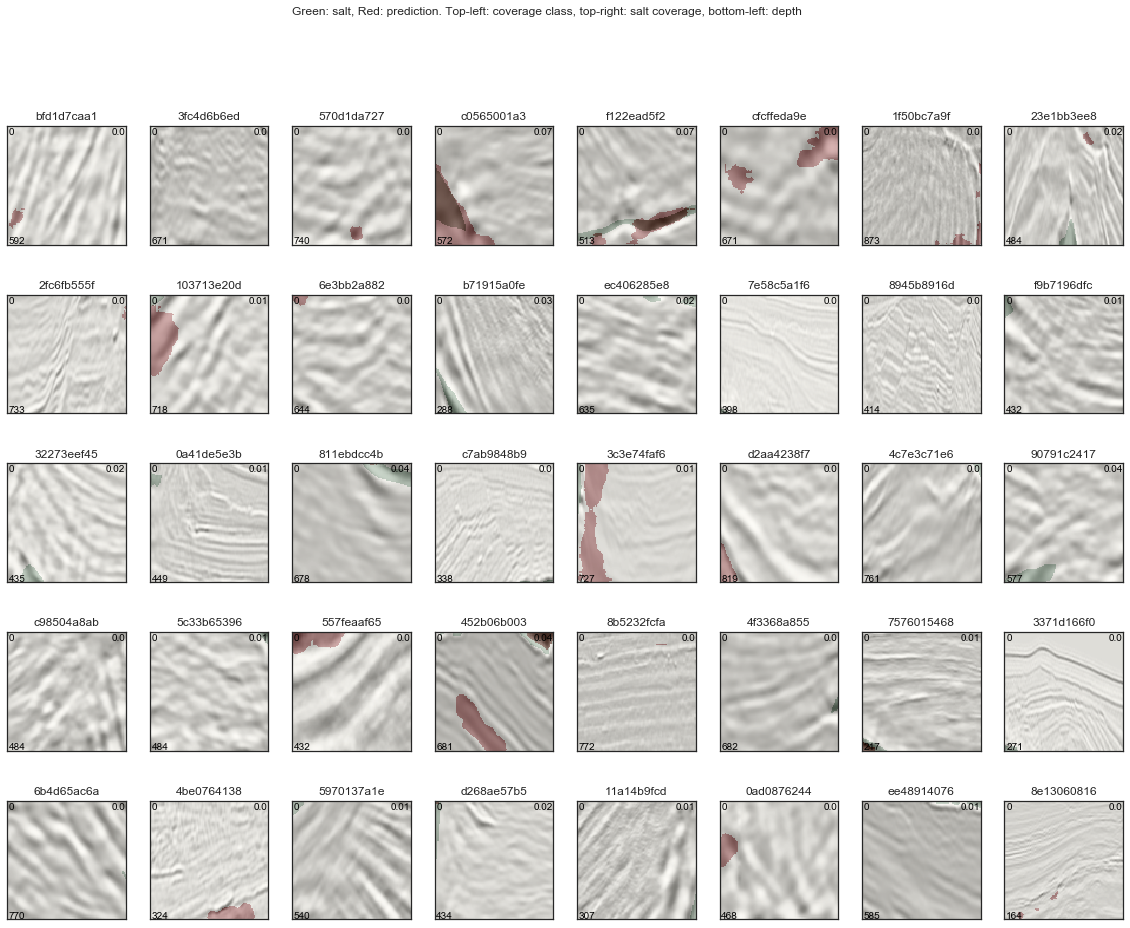

In [40]:
temp_df = valid_df[(valid_df.coverage_class == 0) & (valid_df.outcome == "bad")]

show_images(np.array(temp_df["index"]), images_folder= path_train + 'images', masks_folder= path_train + 'masks',
           predictions=np.array(temp_df["pred"]))

427


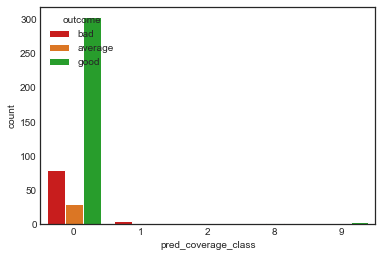

In [47]:
# where do our predictions lie for badly-predicted classes?

temp_df = valid_df[valid_df.coverage_class == 0]
print(temp_df.shape[0])
sns.countplot(x="pred_coverage_class", hue="outcome", data=temp_df, palette=sns.xkcd_palette(["red", "orange", "green"]))

In [64]:
ppred.shape

(1,)

In [73]:
iou_metric(pmask, ppred, print_table = True)

AttributeError: 'function' object has no attribute 'flatten'

In [30]:
# train a separate model just for coverage class=0 images
temp_df = train_df.loc[train_df.coverage_class == 0]


ids_train_zero, ids_valid_zero, x_train_zero, x_valid_zero, y_train_zero, y_valid_zero, cov_train_zero, cov_valid_zero, depth_train, depth_valid = train_test_split(
    temp_df.index.values,
    np.array(temp_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(temp_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    temp_df.coverage.values,
    temp_df.z.values,
    test_size=0.2, random_state=3456)

# data augmentation 
x_train_zero = np.append(x_train_zero, [np.fliplr(x) for x in x_train_zero], axis=0)
y_train_zero = np.append(y_train_zero, [np.fliplr(x) for x in y_train_zero], axis=0)

In [69]:

model_zero = UNet((img_size_target,img_size_target,1),start_ch=8,depth=5,batchnorm=True,upconv=False)
model_zero.compile(loss="binary_crossentropy", optimizer="adam", metrics=[mean_iou])

batch_size = 16
epochs = 25

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('../models/model-tgs-salt-class0-validation-dropout-batchnorm-{epoch:02d}-{val_loss:.2f}.h5', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
tb = TensorBoard(log_dir="../tb_logs", batch_size=batch_size)

history = model_zero.fit(x_train_zero, y_train_zero, validation_data=[x_valid_zero, y_valid_zero], batch_size=batch_size, epochs=epochs, 
                    callbacks=[earlystopper, checkpointer, reduce_lr, tb])

Train on 2498 samples, validate on 313 samples
Epoch 1/25
2498/2498 [==============================] - ETA: 8:37 - loss: 0.9211 - mean_iou: 0.0000e+ - ETA: 7:09 - loss: 0.9062 - mean_iou: 0.1795   - ETA: 6:38 - loss: 0.8910 - mean_iou: 0.24 - ETA: 6:21 - loss: 0.8761 - mean_iou: 0.27 - ETA: 6:10 - loss: 0.8610 - mean_iou: 0.29 - ETA: 6:02 - loss: 0.8518 - mean_iou: 0.30 - ETA: 5:56 - loss: 0.8400 - mean_iou: 0.31 - ETA: 5:50 - loss: 0.8341 - mean_iou: 0.32 - ETA: 5:46 - loss: 0.8243 - mean_iou: 0.33 - ETA: 5:42 - loss: 0.8152 - mean_iou: 0.33 - ETA: 5:38 - loss: 0.8084 - mean_iou: 0.34 - ETA: 5:34 - loss: 0.8011 - mean_iou: 0.34 - ETA: 5:31 - loss: 0.7942 - mean_iou: 0.35 - ETA: 5:28 - loss: 0.7885 - mean_iou: 0.35 - ETA: 5:25 - loss: 0.7835 - mean_iou: 0.35 - ETA: 5:22 - loss: 0.7780 - mean_iou: 0.36 - ETA: 5:19 - loss: 0.7730 - mean_iou: 0.36 - ETA: 5:16 - loss: 0.7683 - mean_iou: 0.36 - ETA: 5:14 - loss: 0.7640 - mean_iou: 0.36 - ETA: 5:11 - loss: 0.7595 - mean_iou: 0.37 - ETA: 5:08

2498/2498 [==============================] - ETA: 5:44 - loss: 0.1385 - mean_iou: 0.49 - ETA: 5:42 - loss: 0.1382 - mean_iou: 0.49 - ETA: 5:40 - loss: 0.1378 - mean_iou: 0.49 - ETA: 5:38 - loss: 0.1377 - mean_iou: 0.49 - ETA: 5:36 - loss: 0.1373 - mean_iou: 0.49 - ETA: 5:34 - loss: 0.1369 - mean_iou: 0.49 - ETA: 5:31 - loss: 0.1366 - mean_iou: 0.49 - ETA: 5:29 - loss: 0.1362 - mean_iou: 0.49 - ETA: 5:27 - loss: 0.1358 - mean_iou: 0.49 - ETA: 5:25 - loss: 0.1354 - mean_iou: 0.49 - ETA: 5:23 - loss: 0.1350 - mean_iou: 0.49 - ETA: 5:21 - loss: 0.1346 - mean_iou: 0.49 - ETA: 5:18 - loss: 0.1342 - mean_iou: 0.49 - ETA: 5:16 - loss: 0.1338 - mean_iou: 0.49 - ETA: 5:14 - loss: 0.1334 - mean_iou: 0.49 - ETA: 5:12 - loss: 0.1330 - mean_iou: 0.49 - ETA: 5:10 - loss: 0.1326 - mean_iou: 0.49 - ETA: 5:07 - loss: 0.1323 - mean_iou: 0.49 - ETA: 5:05 - loss: 0.1319 - mean_iou: 0.49 - ETA: 5:03 - loss: 0.1315 - mean_iou: 0.49 - ETA: 5:01 - loss: 0.1311 - mean_iou: 0.49 - ETA: 4:58 - loss: 0.1308 - mean

2498/2498 [==============================] - ETA: 6:10 - loss: 0.0323 - mean_iou: 0.49 - ETA: 5:55 - loss: 0.0322 - mean_iou: 0.49 - ETA: 5:49 - loss: 0.0322 - mean_iou: 0.49 - ETA: 5:44 - loss: 0.0321 - mean_iou: 0.49 - ETA: 5:41 - loss: 0.0321 - mean_iou: 0.49 - ETA: 5:38 - loss: 0.0320 - mean_iou: 0.49 - ETA: 5:35 - loss: 0.0319 - mean_iou: 0.49 - ETA: 5:33 - loss: 0.0319 - mean_iou: 0.49 - ETA: 5:30 - loss: 0.0318 - mean_iou: 0.49 - ETA: 5:28 - loss: 0.0318 - mean_iou: 0.49 - ETA: 5:26 - loss: 0.0317 - mean_iou: 0.49 - ETA: 5:23 - loss: 0.0316 - mean_iou: 0.49 - ETA: 5:21 - loss: 0.0316 - mean_iou: 0.49 - ETA: 5:18 - loss: 0.0315 - mean_iou: 0.49 - ETA: 5:16 - loss: 0.0315 - mean_iou: 0.49 - ETA: 5:14 - loss: 0.0314 - mean_iou: 0.49 - ETA: 5:11 - loss: 0.0314 - mean_iou: 0.49 - ETA: 5:09 - loss: 0.0313 - mean_iou: 0.49 - ETA: 5:07 - loss: 0.0313 - mean_iou: 0.49 - ETA: 5:05 - loss: 0.0312 - mean_iou: 0.49 - ETA: 5:02 - loss: 0.0311 - mean_iou: 0.49 - ETA: 5:00 - loss: 0.0311 - mean

2498/2498 [==============================] - ETA: 5:47 - loss: 0.0129 - mean_iou: 0.49 - ETA: 5:44 - loss: 0.0129 - mean_iou: 0.49 - ETA: 5:42 - loss: 0.0129 - mean_iou: 0.49 - ETA: 5:40 - loss: 0.0129 - mean_iou: 0.49 - ETA: 5:37 - loss: 0.0129 - mean_iou: 0.49 - ETA: 5:35 - loss: 0.0129 - mean_iou: 0.49 - ETA: 5:33 - loss: 0.0129 - mean_iou: 0.49 - ETA: 5:30 - loss: 0.0129 - mean_iou: 0.49 - ETA: 5:28 - loss: 0.0129 - mean_iou: 0.49 - ETA: 5:26 - loss: 0.0129 - mean_iou: 0.49 - ETA: 5:24 - loss: 0.0129 - mean_iou: 0.49 - ETA: 5:21 - loss: 0.0128 - mean_iou: 0.49 - ETA: 5:19 - loss: 0.0128 - mean_iou: 0.49 - ETA: 5:17 - loss: 0.0128 - mean_iou: 0.49 - ETA: 5:15 - loss: 0.0128 - mean_iou: 0.49 - ETA: 5:12 - loss: 0.0128 - mean_iou: 0.49 - ETA: 5:10 - loss: 0.0127 - mean_iou: 0.49 - ETA: 5:08 - loss: 0.0127 - mean_iou: 0.49 - ETA: 5:06 - loss: 0.0127 - mean_iou: 0.49 - ETA: 5:04 - loss: 0.0127 - mean_iou: 0.49 - ETA: 5:01 - loss: 0.0127 - mean_iou: 0.49 - ETA: 4:59 - loss: 0.0127 - mean

2498/2498 [==============================] - ETA: 5:44 - loss: 0.0067 - mean_iou: 0.49 - ETA: 5:43 - loss: 0.0067 - mean_iou: 0.49 - ETA: 5:41 - loss: 0.0067 - mean_iou: 0.49 - ETA: 5:40 - loss: 0.0067 - mean_iou: 0.49 - ETA: 5:37 - loss: 0.0067 - mean_iou: 0.49 - ETA: 5:35 - loss: 0.0067 - mean_iou: 0.49 - ETA: 5:33 - loss: 0.0067 - mean_iou: 0.49 - ETA: 5:31 - loss: 0.0067 - mean_iou: 0.49 - ETA: 5:28 - loss: 0.0067 - mean_iou: 0.49 - ETA: 5:26 - loss: 0.0066 - mean_iou: 0.49 - ETA: 5:24 - loss: 0.0066 - mean_iou: 0.49 - ETA: 5:22 - loss: 0.0066 - mean_iou: 0.49 - ETA: 5:20 - loss: 0.0066 - mean_iou: 0.49 - ETA: 5:17 - loss: 0.0066 - mean_iou: 0.49 - ETA: 5:15 - loss: 0.0066 - mean_iou: 0.49 - ETA: 5:13 - loss: 0.0066 - mean_iou: 0.49 - ETA: 5:11 - loss: 0.0066 - mean_iou: 0.49 - ETA: 5:08 - loss: 0.0066 - mean_iou: 0.49 - ETA: 5:06 - loss: 0.0066 - mean_iou: 0.49 - ETA: 5:04 - loss: 0.0066 - mean_iou: 0.49 - ETA: 5:02 - loss: 0.0066 - mean_iou: 0.49 - ETA: 4:59 - loss: 0.0066 - mean

2498/2498 [==============================] - ETA: 5:44 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:43 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:41 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:39 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:37 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:35 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:32 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:30 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:28 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:26 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:24 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:21 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:19 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:17 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:15 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:13 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:10 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:08 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:06 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:04 - loss: 0.0040 - mean_iou: 0.49 - ETA: 5:01 - loss: 0.0040 - mean_iou: 0.49 - ETA: 4:59 - loss: 0.0040 - mean

2498/2498 [==============================] - ETA: 5:45 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:42 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:41 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:39 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:37 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:35 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:32 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:30 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:28 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:26 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:23 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:21 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:19 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:17 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:15 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:12 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:10 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:08 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:06 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:03 - loss: 0.0026 - mean_iou: 0.49 - ETA: 5:01 - loss: 0.0026 - mean_iou: 0.49 - ETA: 4:59 - loss: 0.0026 - mean

2498/2498 [==============================] - ETA: 5:44 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:43 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:41 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:39 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:37 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:35 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:33 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:30 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:28 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:26 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:24 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:22 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:19 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:17 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:15 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:13 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:10 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:08 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:06 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:04 - loss: 0.0018 - mean_iou: 0.49 - ETA: 5:01 - loss: 0.0018 - mean_iou: 0.49 - ETA: 4:59 - loss: 0.0018 - mean

KeyboardInterrupt: 

In [ ]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))

ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["mean_iou"], label="Train Mean_IoU")
ax_acc.plot(history.epoch, history.history["val_mean_iou"], label="Validation Mean_IoU")

In [20]:
best_zero_model = load_model('../models/model-tgs-salt-class0-validation-dropout-batchnorm-07-0.01.h5',
                       custom_objects={"mean_iou": mean_iou})

In [31]:
# threshold sweep 

preds_valid_zero = best_zero_model.predict(x_valid_zero).reshape(-1, img_size_target, img_size_target)
preds_valid_zero = np.array([downsample(x) for x in preds_valid_zero])
y_valid_zero_ori = np.array([train_df.loc[idx].masks for idx in ids_valid_zero])

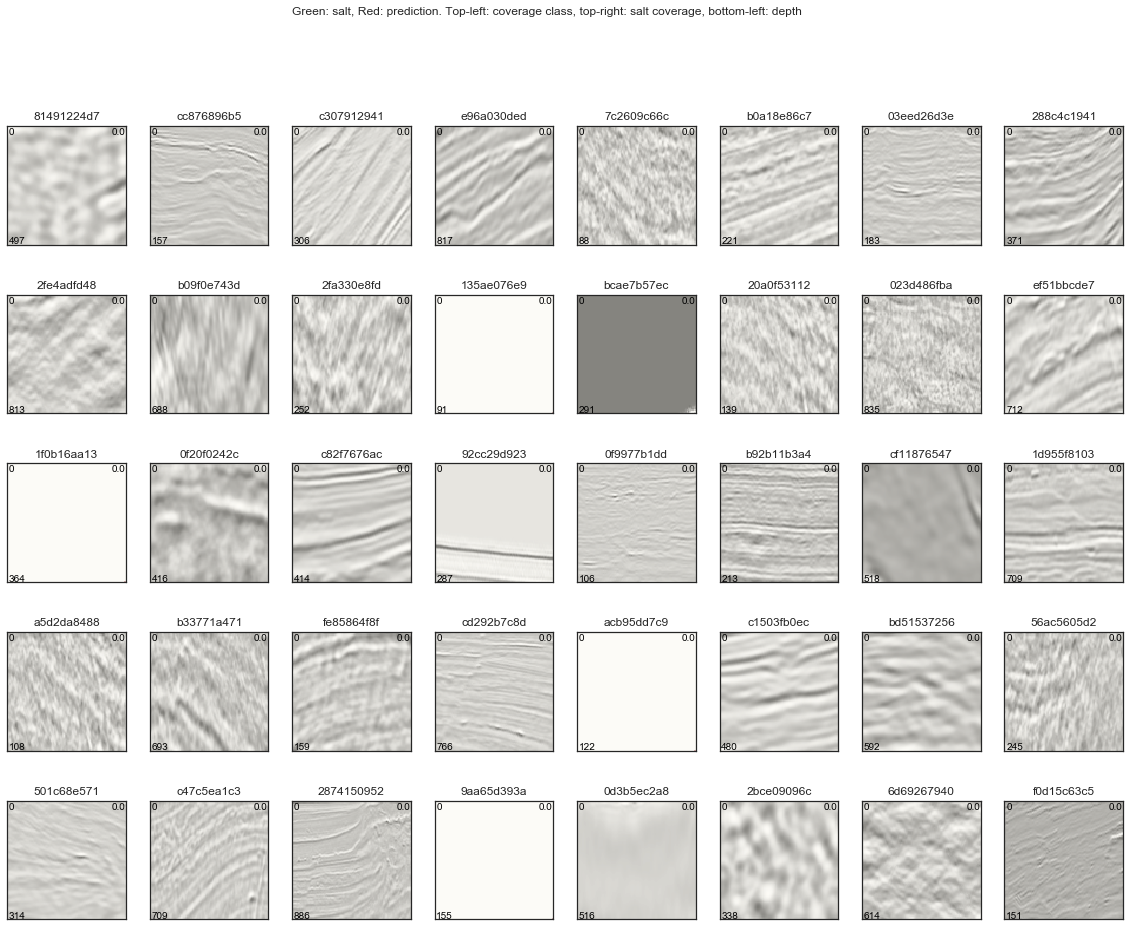

In [36]:
show_images(ids_valid_zero, images_folder= path_train + 'images', masks_folder= path_train + 'masks',
           predictions=preds_valid_zero)

In [83]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid_zero_ori, np.int32(preds_valid_zero > threshold)) for threshold in tqdm_notebook(thresholds)])

In [84]:
threshold_zero_best_index = np.argmax(ious)
iou_best = ious[threshold_zero_best_index]
threshold_zero_best = thresholds[threshold_zero_best_index]

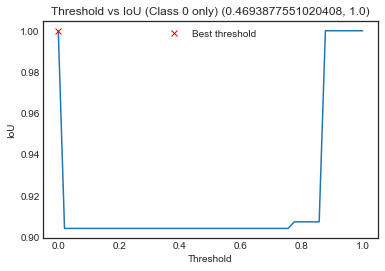

In [85]:
plt.plot(thresholds, ious)
plt.plot(threshold_zero_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU (Class 0 only) ({}, {})".format(threshold_best, iou_best))
plt.legend()

threshold_zero_best_index = 0.5

# Submission

In [63]:
x_test = np.array([upsample(np.array(load_img("../data/test/images/{}.png".format(idx), color_mode = "grayscale"))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

preds_test = best_model.predict(x_test)
preds_zero_test = best_zero_model.predict(x_test)

In [64]:
preds_final = np.zeros(preds_test.shape)
for i in range(preds_test.shape[0]):
    pred_mask = np.round(preds_test[i] > threshold_best)
    pred_coverage_class = np.trunc(np.sum(pred_mask) * 10 / (128*128))
    preds_final[i] = pred_mask if pred_coverage_class > 0 else np.round(preds_zero_test[i] > 0.5)

In [65]:
preds_final.shape

(18000, 128, 128, 1)

In [66]:
pred_dict = {idx: rle_encode(np.round(downsample(preds_final[i]))) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')